In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 21 05:03:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# pip uninstall wandb -y

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


## Why Wandb?

Wandb (Weights & Biases) is a powerful tool for tracking, visualizing, and analyzing machine learning experiments. Here are two key uses:

1. Experiment Tracking: Wandb allows researchers and developers to monitor and log various parameters, metrics, and outputs from their machine learning experiments in real-time. This enables easy comparison between different models, hyperparameters, and datasets, facilitating better decision-making in the model development process.

2. Visualization and Collaboration: With Wandb, users can create interactive visualizations of their experimental results, such as learning curves, confusion matrices, and model architectures. These visualizations help in gaining insights into model performance and behavior. Additionally, Wandb provides collaborative features, allowing team members to share and discuss results, thus fostering collaboration and knowledge sharing within research teams.

In [ ]:
import wandb

# Reauthenticate with Wandb
wandb.login(key = "********")
wandb.init(project='GPT2_check_ml')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rajmaharajwala514 (usc_databuddies). Use `wandb login --relogin` to force relogin


In [ ]:
cd /content/drive/MyDrive/Chatbot_InsuranceQA

/content/drive/.shortcut-targets-by-id/1z6j7eyH00Do8s4ncqmY2gDD8bpCZSNGQ/Chatbot_InsuranceQA


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1z6j7eyH00Do8s4ncqmY2gDD8bpCZSNGQ/Chatbot_InsuranceQA'

In [ ]:
!pip install transformers==4.38.2

In [ ]:
!pip install -U PyPDF2
!pip install python-docx

In [ ]:
!pip install transformers[torch]==4.38.2

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import re
from PyPDF2 import PdfReader
import os
import docx
import random
import torch
from tqdm import tqdm
import shutil
from torch.autograd import Variable
from tqdm.notebook import tqdm_notebook as tqdmnb
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback, TrainerCallback
from transformers import get_cosine_schedule_with_warmup
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, TrainerCallback

In [ ]:
# Functions to read different file types
def read_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_reader = PdfReader(file)
        text = ""
        for page_num in range(len(pdf_reader.pages)):
            text += pdf_reader.pages[page_num].extract_text()
    return text

def read_word(file_path):
    doc = docx.Document(file_path)
    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

def read_txt(file_path):
    with open(file_path, "r") as file:
        text = file.read()
    return text

def read_documents_from_directory(directory, type = "train"):
    combined_text = ""
    for filename in os.listdir(directory):
        if not filename.startswith(f"{type}_QA"):
            continue
        file_path = os.path.join(directory, filename)
        if filename.endswith(".pdf"):
            combined_text += read_pdf(file_path)
        elif filename.endswith(".docx"):
            combined_text += read_word(file_path)
        elif filename.endswith(".txt"):
            combined_text += read_txt(file_path)
    return combined_text


In [ ]:
ls

AkashUI.ipynb                    logs/                      train_dataset.csv
app.ipynb                        model/                     validation_dataset.csv
data/                            project_architecture.gdoc  vectorstore.index
fine_tuned_distilbert_model.pth  RAJ_Copy_of_app.ipynb      wandb/
htmlTemplates.py                 test_dataset.csv


# Data Processing & Augmentation

In [ ]:


"""
Pool is generated by SOLR.
File name that includes raw contains text with original version.
File name that includes token contains text tokenized with Stanford Tokenizer.
We split the whole corpus into train/valid/test three parts. File name that includes train/valid/test corresponds to each part.

For all tokens starting with idx_ , please refer to the vocabulary file for the corresponding word.

For all train/valid/test files, format is same, with various answer pool size:
 <Domain><TAB><QUESTION><TAB><Groundtruth><TAB><Pool>

For InsuranceQA.question.anslabel.*:
<Domain><TAB><QUESTION><TAB><Groundtruth>

For InsuranceQA.label2answer.*
<Answer Label><TAB><Answer Text>

For vocabulary file:
<word index><TAB><original word>
"""


def load_vocabulary(vocab_path, label_path):
    id_to_word = {}
    with open(vocab_path) as f:
        lines = f.readlines()
        for l in tqdm(lines, desc='Loading Vocabulary'):
            d = l.rstrip().split('\t')
            if d[0] not in id_to_word:
                id_to_word[d[0]] = d[1]

    label_to_ans = {}
    label_to_ans_text = {}
    with open(label_path) as f:
        lines = f.readlines()
        for l in tqdm(lines, desc='Loading Labels'):
            label, answer = l.rstrip().split('\t')
            if label not in label_to_ans:
                label_to_ans[label] = answer
                label_to_ans_text[label] = [id_to_word[t] for t in answer.split(' ')]
    return id_to_word, label_to_ans, label_to_ans_text


def data_load(fpath, id_to_word, label_to_ans_text, type = "Training", label = False):
    data = []
    with open(fpath) as f:
        lines = f.readlines()
        for l in tqdm(lines, desc = f'Loading {type} Data'):
            d = l.rstrip().split('\t')
            q = [id_to_word[t] for t in d[1].split(' ')] # question
            if label == True:
              poss = [t for t in d[2].split(' ')] # ground-truth
              cands = [t for t in d[3].split(' ')] # candidate-pool
            else:
              poss = [label_to_ans_text[t] for t in d[2].split(' ')] # ground-truth
              cands = [label_to_ans_text[t] for t in d[3].split(' ') if t not in d[2]] # candidate-pool without ground-truth
            data.append((q, poss, cands))
    return data


# data load main
paths = {
    'vocab_path': 'data/V2/vocabulary',
    'label_path': 'data/V2/InsuranceQA.label2answer.token.encoded',
    'train_path': 'data/V2/InsuranceQA.question.anslabel.token.500.pool.solr.train.encoded',
}

id_to_word, _, label_to_ans_text = load_vocabulary(paths['vocab_path'], paths['label_path'])
train = data_load(paths['train_path'], id_to_word, label_to_ans_text)
train_df = pd.DataFrame(train, columns=['Question', 'Groundtruth', 'Candidate_Pool'])

Loading Training Data: 100%|██████████| 12889/12889 [00:10<00:00, 1284.96it/s]


In [ ]:
train_df.head(2)

,Question,Groundtruth,Candidate_Pool
0,"[Is, Disability, Insurance, Required, By, Law, ?]","[[Not, generally, ., There, are, five, states,...","[[Life, insurance, unlike, health, insurance, ..."
1,"[Can, Creditors, Take, Life, Insurance, After,...","[[If, the, person, who, passed, away, was, the...","[[Creditors, can, not, go, after, the, life, i..."


In [ ]:
"""
Get Complete Training QA data in txt format
"""

os.makedirs('data/final', exist_ok=True)

# Path to the output text file
train_file_path = 'data/final/train_complete_QA.txt'
open(train_file_path, 'x').close() if not os.path.exists(train_file_path) else None

# Open the text file for writing
with open(train_file_path, 'w') as file:
    # Iterate over rows in the DataFrame
    for index, row in train_df.iterrows():
        # Format the line with '[A]' between the columns
        line = "[Q] "+" ".join(row['Question'])+"\n[A] "+ " ".join(row['Groundtruth'][0])+"\n\n"
        # Write the formatted line to the file
        file.write(line)

print("Sample Train file has been written successfully for 12889 records.")

Sample Train file has been written successfully for 12889 records.


In [ ]:
"""
Get Subset of Training QA data in txt format for Valid and Test Set
"""

train_file_path = 'data/final/train_6050_QA.txt'
open(train_file_path, 'x').close() if not os.path.exists(train_file_path) else None

with open(train_file_path, 'w') as file:
    for index, row in train_df.iloc[:6050].iterrows():
        line = "[Q] "+" ".join(row['Question'])+"\n[A] "+ " ".join(row['Groundtruth'][0])+"\n\n"
        file.write(line)

print("Sample Train file has been written successfully for 6050 records.")

Sample Train file has been written successfully for 6050 records.


In [ ]:
"""
Spliting the training data into multiple Chunks with only Question which would later used for Data Augmentation
by converting original question into paraphrased version of questions.
"""

os.makedirs('data/only_questions', exist_ok=True)

for i in range(0,6050,50):
    train_file_path = f'data/only_questions/train_Q_{i}.txt'
    open(train_file_path, 'x').close() if not os.path.exists(train_file_path) else None
    with open(train_file_path, 'w') as file:
        for index, row in train_df.iterrows():
            if(index>=i and index<i+50):
                line = "[Q] "+" ".join(row['Question'])+"\n"
                file.write(line)
            elif(index>=i+50):
                break
    print("Train "+str(i)+" file has been written successfully.")

In [ ]:
"""
After Paraphrasing all this question files generated above using Open AI API ~ Done Locally
"""
# step 1: Merge all this files to generate file with all Paraphrased Question
# 50 paraphrased questions per file
directory = 'data/final_questions'
txt_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
txt_files = [f for f in txt_files if f.split('.')[0].isdigit()]
txt_files.sort(key=lambda x: int(x.split('.')[0]))

print(txt_files)
with open('data/final/merged_questions.txt', 'w') as outfile: # file with all Paraphrased Question #Dimen: 6050 Q
    for txt_file in txt_files:
        with open(os.path.join(directory, txt_file), 'r') as infile:
            outfile.write(infile.read())
            outfile.write('\n')

['0.txt', '50.txt', '100.txt', '150.txt', '200.txt', '250.txt', '300.txt', '350.txt', '400.txt', '450.txt', '500.txt', '550.txt', '600.txt', '650.txt', '700.txt', '750.txt', '800.txt', '850.txt', '900.txt', '950.txt', '1000.txt', '1050.txt', '1100.txt', '1150.txt', '1200.txt', '1250.txt', '1300.txt', '1350.txt', '1400.txt', '1450.txt', '1500.txt', '1550.txt', '1600.txt', '1650.txt', '1700.txt', '1750.txt', '1800.txt', '1850.txt', '1900.txt', '1950.txt', '2000.txt', '2050.txt', '2100.txt', '2150.txt', '2200.txt', '2250.txt', '2300.txt', '2350.txt', '2400.txt', '2450.txt', '2500.txt', '2550.txt', '2600.txt', '2650.txt', '2700.txt', '2750.txt', '2800.txt', '2850.txt', '2900.txt', '2950.txt', '3000.txt', '3050.txt', '3100.txt', '3150.txt', '3200.txt', '3250.txt', '3300.txt', '3350.txt', '3400.txt', '3450.txt', '3500.txt', '3550.txt', '3600.txt', '3650.txt', '3700.txt', '3750.txt', '3800.txt', '3850.txt', '3900.txt', '3950.txt', '4000.txt', '4050.txt', '4100.txt', '4150.txt', '4200.txt', '4

In [ ]:
"""
Step 2: merge answer to the paraphrased question based on train_6050_QA.txt, and merged_questions.txt
"""

def read_questions_paraphrased(file_path):
    with open(file_path, 'r') as file:
        questions_paraphrased = [line.strip() for line in file.readlines()]
    return questions_paraphrased

def read_questions_and_answers(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        questions = [line.strip()[4:] for line in lines if line.startswith('[Q]')]
        answers = [line.strip()[4:] for line in lines if line.startswith('[A]')]
    return questions, answers

def write_main_test_file(questions_paraphrased, questions, answers, output_file):
    with open(output_file, 'w') as file:
        for paraphrased, question, answer in zip(questions_paraphrased, questions, answers):
            file.write(f'[Q] {paraphrased}\n[A] {answer}\n\n')

paraphrased_file = 'data/final/merged_questions.txt' #Q-Paraphrased #6050
qa_file = 'data/final/train_6050_QA.txt' #Q-Question_Actual.  A-Answer
output_file = 'data/final/main_test.txt' #Q-Paraphrased.  A-Answer

questions_paraphrased = read_questions_paraphrased(paraphrased_file)
questions, answers = read_questions_and_answers(qa_file)
write_main_test_file(questions_paraphrased, questions, answers, output_file)
print(f"Generated {output_file} file")

Generated data/final/main_test.txt file


In [ ]:
ls data/final

main_test.txt  merged_questions.txt  train_6050_QA.txt  train_complete_QA.txt


In [ ]:
with open("data/final/train_complete_QA.txt", 'r') as file:
  for line in file.readlines()[:5]: # top 5 lines
    print(line)

[Q] Is Disability Insurance Required By Law ?

[A] Not generally . There are five states that require most all employers carry short term disability insurance on their employees . These states are : California , Hawaii , New Jersey , New York , and Rhode Island . Besides this mandatory short term disability law , there is no other legislative imperative for someone to purchase or be covered by disability insurance .



[Q] Can Creditors Take Life Insurance After Death ?

[A] If the person who passed away was the one with the debt , creditors generally can not take the life insurance proceeds left as long as the beneficiary was a person . The money then belongs to that beneficiary , and as long as creditors do not have a claim against the beneficiary , they can not take life insurance proceeds from them .



In [ ]:
with open("data/final/main_test.txt", 'r') as file:
  for line in file.readlines()[:5]: # top 5 lines
    print(line)

[Q] Is it mandatory by law to have disability insurance?

[A] Not generally . There are five states that require most all employers carry short term disability insurance on their employees . These states are : California , Hawaii , New Jersey , New York , and Rhode Island . Besides this mandatory short term disability law , there is no other legislative imperative for someone to purchase or be covered by disability insurance .



[Q] Can life insurance be seized by creditors after someone dies?

[A] If the person who passed away was the one with the debt , creditors generally can not take the life insurance proceeds left as long as the beneficiary was a person . The money then belongs to that beneficiary , and as long as creditors do not have a claim against the beneficiary , they can not take life insurance proceeds from them .



In [ ]:
ls data/final

main_test.txt  merged_questions.txt  train_6050_QA.txt  train_complete_QA.txt


In [ ]:
def read_main_test_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

def write_file(file_path, lines):
    with open(file_path, 'w') as file:
        file.writelines(lines)

def generate_valid_and_test_files(main_test_lines):
    # Extract question-answer pairs
    qa_pairs = []
    current_pair = ""
    for line in main_test_lines:
        if line.startswith("[Q]"):
            current_pair = line
        elif line.startswith("[A]"):
            current_pair += line + '\n'
            qa_pairs.append(current_pair)

    # Shuffle the pairs
    random.shuffle(qa_pairs)

    # Determine split index for 50% each for validation and testing
    split_index = int(0.5 * len(qa_pairs))

    # Split into validation and testing sets
    validation_data = qa_pairs[:split_index]
    testing_data = qa_pairs[split_index:split_index*2]

    return validation_data, testing_data

# Function to count the number of questions and answers in a file
def count_qa_in_file(file_path):
    question_count = 0
    answer_count = 0
    with open(file_path, 'r') as file:
        for line in file:
            if "[Q]" in line:
                question_count += 1
            elif "[A]" in line:
                answer_count += 1
    return question_count, answer_count

def main():
    import os

    # File paths
    main_test_file = "data/final/main_test.txt"
    valid_file = "data/final/valid_complete_QA.txt"
    test_file = "data/final/test_complete_QA.txt"

    # Read the main test file and generate valid/test data
    main_test_lines = read_main_test_file(main_test_file)
    validation_data, testing_data = generate_valid_and_test_files(main_test_lines)

    # Write the generated data to files
    open(valid_file, 'x').close() if not os.path.exists(valid_file) else None
    open(test_file, 'x').close() if not os.path.exists(test_file) else None
    write_file(valid_file, validation_data)
    write_file(test_file, testing_data)

    # Print the first few lines of validation and testing data
    print("First 2 QA of Validation data\n")
    with open(valid_file, 'r') as file:
        for line in file.readlines()[:5]:
            print(line)

    print("\n\nFirst 2 QA of Test data\n")
    with open(test_file, 'r') as file:
        for line in file.readlines()[:5]:
            print(line)

    # Count the number of questions and answers in the validation and test files
    valid_q_count, valid_a_count = count_qa_in_file(valid_file)
    test_q_count, test_a_count = count_qa_in_file(test_file)

    # Print the counts
    print(f"\nValidation File: {valid_file}")
    print(f"Number of Questions: {valid_q_count}")
    print(f"Number of Answers: {valid_a_count}")

    print(f"\nTest File: {test_file}")
    print(f"Number of Questions: {test_q_count}")
    print(f"Number of Answers: {test_a_count}")


main()

First 2 QA of Validation data

[Q] When is it possible to switch auto insurance providers?

[A] That is a great question ! Your life insurance policy through your work place is a group life term policy . It is a group policy because the same conditions and terms generally apply to all members of your workforce , and it is a term policy because it ends one year after enrolling - which is why there is an enrollment period each fall that you re-up the coverage or change it . I hope that helps , thanks for asking !



[Q] Are ED medications covered by health insurance?

[A] If your health insurance plan has it 's pharmacy benefits integrated then it probably will . The type of plan and the scope of it 's coverage will dictate how exactly such a medication is handled . If one has a `` rich '' level of coverage then one should have no problems what-so-ever , however with plans that offer `` thinner '' coverage and benefit options one may have to have their Dr. contact the insurance company t

In [ ]:
!pip list | grep -E 'transformers|accelerate|torch|tensorflow'

accelerate                       0.30.0
tensorflow                       2.15.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.37.0
tensorflow-metadata              1.15.0
tensorflow-probability           0.23.0
torch                            2.2.1+cu121
torchaudio                       2.2.1+cu121
torchdata                        0.7.1
torchsummary                     1.5.1
torchtext                        0.17.1
torchvision                      0.17.1+cu121
transformers                     4.38.2


# Llama 3 Finetuning Test

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback, TrainerCallback
import torch
from transformers import get_cosine_schedule_with_warmup
from transformers import LlamaTokenizer, LlamaForCausalLM, AutoTokenizer
import os

output_dir = 'model/LLaMA_3_custom_q_and_a'

class EvaluateTestSetCallback(TrainerCallback):
    """Custom callback for evaluating the test set perplexity every 10 epochs."""
    def __init__(self, trainer, test_dataset):
        super().__init__()
        self.trainer = trainer
        self.test_dataset = test_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating test set after epoch {state.epoch}")
            test_results = self.trainer.evaluate(eval_dataset=self.test_dataset)
            test_loss = test_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(test_loss)).item()
            print(f"\tTest Set Loss: {test_loss:.6f}")
            print(f"\tTest Set Perplexity: {perplexity:.2f}\n")


def train(train_args, train_file_path, valid_file_path, test_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_steps):
    # Load tokenizer and datasets
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    valid_dataset = load_dataset(valid_file_path, tokenizer)
    test_dataset = load_dataset(test_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    # Initialize model
    # Save tokenizer
    tokenizer.save_pretrained(output_dir)
    model = LlamaForCausalLM.from_pretrained(model_name)
    model.save_pretrained(output_dir)

    # Define training arguments
    training_args = train_args

    # Calculate total steps
    total_steps = len(train_dataset) // per_device_train_batch_size * num_train_epochs

    # # Initialize the optimizer separately and set the learning rate
    # optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)

    # # Define the optimizer and scheduler tuple
    # optimizers = (optimizer, get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps))

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,  # Provide validation dataset
        #optimizers=optimizers,
    )

    # Attach the test evaluation callback
    test_callback = EvaluateTestSetCallback(trainer, test_dataset)
    trainer.add_callback(test_callback)

    # Train model
    trainer.train()

    # Save the model
    trainer.save_model()

# Final Test, train, valid usage
train_file_path = "data/qa/train_sample_QA.txt"
valid_file_path = "data/qa/valid_sample_QA.txt"
test_file_path = "data/qa/test_sample_QA.txt"
model_name = 'meta-llama/Meta-Llama-3-8B'
output_dir = 'model/LLaMA_3_custom_q_and_a'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
overwrite_output_dir = False
per_device_train_batch_size = 2
num_train_epochs = 100
save_steps = 1000

train_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        logging_dir='./logs',  # Directory for storing logs
        logging_steps=7,  # Log every 50 steps
        save_steps=save_steps,
        metric_for_best_model='eval_loss',  # Use eval loss to evaluate best model
        gradient_accumulation_steps=2,  # Accumulate gradients on several steps
        gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
        fp16=False,  # Disabled fp16 for faster training
        learning_rate=1e-5,  # Starting learning rate
        lr_scheduler_type='cosine', # Type of the learning rate scheduler
        warmup_steps=200,
        max_grad_norm=1.0,  # Maximum norm of the gradients (gradient clipping)
        evaluation_strategy='epoch',  # Evaluate after each epoch
        eval_steps=7, # Evaluate after every 7 steps
        #lr_scheduler_type="constant"
        weight_decay=0.01,
        adam_epsilon=1e-8,
        optim="adafactor"
    )

model = train(train_args, train_file_path, valid_file_path, test_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_steps)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 213.06 MiB is free. Process 28991 has 14.54 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 13.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", legacy = False)

input_string = "Hello, how are you?"
tokens = tokenizer.encode(input_string, return_tensors='pt')

print(tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tensor([[128000,   9906,     11,   1268,    527,    499,     30]])


# Llama 2 Finetuning Testining

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
from transformers import EarlyStoppingCallback, TrainerCallback
import torch
from transformers import get_cosine_schedule_with_warmup
from transformers import LlamaTokenizer, LlamaForCausalLM, AutoTokenizer
import os

output_dir = 'model/LLaMA_2_custom_q_and_a'

class EvaluateTestSetCallback(TrainerCallback):
    """Custom callback for evaluating the test set perplexity every 10 epochs."""
    def __init__(self, trainer, test_dataset):
        super().__init__()
        self.trainer = trainer
        self.test_dataset = test_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating test set after epoch {state.epoch}")
            test_results = self.trainer.evaluate(eval_dataset=self.test_dataset)
            test_loss = test_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(test_loss)).item()
            print(f"\tTest Set Loss: {test_loss:.6f}")
            print(f"\tTest Set Perplexity: {perplexity:.2f}\n")


def train(train_args, train_file_path, valid_file_path, test_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_steps):
    # Load tokenizer and datasets
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    valid_dataset = load_dataset(valid_file_path, tokenizer)
    test_dataset = load_dataset(test_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    # Initialize model
    # Save tokenizer
    tokenizer.save_pretrained(output_dir)
    model = LlamaForCausalLM.from_pretrained(model_name)
    model.save_pretrained(output_dir)

    # Define training arguments
    training_args = train_args

    # Calculate total steps
    total_steps = len(train_dataset) // per_device_train_batch_size * num_train_epochs

    # # Initialize the optimizer separately and set the learning rate
    # optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)

    # # Define the optimizer and scheduler tuple
    # optimizers = (optimizer, get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps))

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,  # Provide validation dataset
        #optimizers=optimizers,
    )

    # Attach the test evaluation callback
    test_callback = EvaluateTestSetCallback(trainer, test_dataset)
    trainer.add_callback(test_callback)

    # Train model
    trainer.train()

    # Save the model
    trainer.save_model()

# Final Test, train, valid usage
train_file_path = "data/qa/train_sample_QA.txt"
valid_file_path = "data/qa/valid_sample_QA.txt"
test_file_path = "data/qa/test_sample_QA.txt"
model_name = 'meta-llama/Llama-2-7b-chat-hf'
output_dir = 'model/LLaMA_2_custom_q_and_a'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
overwrite_output_dir = False
per_device_train_batch_size = 2
num_train_epochs = 50
save_steps = 1000

train_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        logging_dir='./logs',  # Directory for storing logs
        logging_steps=7,  # Log every 50 steps
        save_steps=save_steps,
        metric_for_best_model='eval_loss',  # Use eval loss to evaluate best model
        gradient_accumulation_steps=2,  # Accumulate gradients on several steps
        gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
        fp16=False,  # Disabled fp16 for faster training
        learning_rate=1e-5,  # Starting learning rate
        lr_scheduler_type='cosine', # Type of the learning rate scheduler
        warmup_steps=200,
        max_grad_norm=1.0,  # Maximum norm of the gradients (gradient clipping)
        evaluation_strategy='epoch',  # Evaluate after each epoch
        eval_steps=7, # Evaluate after every 7 steps
        #lr_scheduler_type="constant"
        weight_decay=0.01,
        adam_epsilon=1e-8,
        optim="adafactor"
    )

model = train(train_args, train_file_path, valid_file_path, test_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_steps)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 93.06 MiB is free. Process 41732 has 14.65 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 5.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Llama 3 using Qlora

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1z6j7eyH00Do8s4ncqmY2gDD8bpCZSNGQ/Chatbot_InsuranceQA'

In [ ]:
# !pip uninstall huggingface_hub -y

In [ ]:
# !pip install huggingface_hub==0.14.1

In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip install peft==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
!pip install -q bitsandbytes trl --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 42.1 MB/s eta 0:00:00


In [ ]:
pip show peft

Name: peft
Version: 0.7.0
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: sourab@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: accelerate, huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 


In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    logging,
    EarlyStoppingCallback,
    pipeline,
)
from peft import LoraConfig, PeftModel
from datasets import load_dataset as hf_load_dataset, Dataset
from trl import SFTTrainer

# Nvidia Llama 3

In [ ]:
# import os
# import torch
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     BitsAndBytesConfig,
#     TrainingArguments,
#     TrainerCallback,
#     logging,
#     EarlyStoppingCallback,
# )
# from peft import LoraConfig, PeftModel
# from datasets import load_dataset as hf_load_dataset, Dataset
# from trl import SFTTrainer
# import locale

# # Configurations
# model_name = 'nvidia/Llama3-ChatQA-1.5-8B'
# output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA'
# new_model = "Nvidia_Llama-3-8b-chat-finetune"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # QLoRA parameters
# lora_r = 64
# lora_alpha = 16
# lora_dropout = 0.1

# # bitsandbytes parameters
# use_4bit = True
# bnb_4bit_compute_dtype = "float16"
# bnb_4bit_quant_type = "nf4"
# use_nested_quant = False

# # Define custom dataset loading function for QA format
# def load_custom_text_dataset(file_path, system_text):
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     if not lines:
#         raise ValueError(f"Empty data file: {file_path}")

#     data = []
#     current_qa = {"text": ""}
#     context = ""
#     for line in lines:
#         if line.startswith("[C]"):
#             context = line[len("[C]"):].strip()
#         elif line.startswith("[Q]"):
#             if current_qa["text"]:
#                 data.append(current_qa)
#             question = line[len("[Q]"):].strip()
#             current_qa = {"text": format_prompt(system_text, context, question, None)}
#         elif line.startswith("[A]"):
#             answer = line[len("[A]"):].strip()
#             current_qa["text"] = format_prompt(system_text, context, question, answer)
#             data.append(current_qa)
#             current_qa = {"text": ""}
#         else:
#             continue

#     if current_qa["text"]:
#         data.append(current_qa)

#     if not data:
#         raise ValueError("No data loaded from the file.")

#     return Dataset.from_list(data)

# # Function to format prompts
# def format_prompt(system, context, question, answer=None):
#     prompt = f"System: {system}\n\n"
#     if context:
#         prompt += f"{context}\n\n"
#     prompt += f"User: {question}\n\nAssistant: "
#     if answer:
#         prompt += f"{answer}\n\nUser:"
#     return prompt

# # System text
# system_text = "This is a chat between a user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. The assistant should also indicate when the answer cannot be found in the context."

# # Load datasets
# train_dataset = load_custom_text_dataset("data/qa/train_sample_QA.txt", system_text)
# valid_dataset = load_custom_text_dataset("data/qa/valid_sample_QA.txt", system_text)
# test_dataset = load_custom_text_dataset("data/qa/test_sample_QA.txt", system_text)

# # Load tokenizer and model with QLoRA configuration
# tokenizer = AutoTokenizer.from_pretrained('nvidia/Llama3-ChatQA-1.5-8B')

# def tokenize_function(examples):
#     return tokenizer(examples['text'], padding="max_length", truncation=True)

# # Tokenize the datasets while keeping the text field
# train_dataset = train_dataset.map(tokenize_function, batched=True)
# valid_dataset = valid_dataset.map(tokenize_function, batched=True)
# test_dataset = test_dataset.map(tokenize_function, batched=True)

# # Set the format for PyTorch without removing the text column
# train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
# valid_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
# test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])

# # Check the formatting
# train_dataset[0]

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    logging,
    EarlyStoppingCallback,
)
from peft import LoraConfig, PeftModel
from datasets import load_dataset as hf_load_dataset, Dataset
from trl import SFTTrainer

# Configurations
model_name = 'nvidia/Llama3-ChatQA-1.5-8B'
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA'
new_model = "Nvidia_Llama-3-8b-chat-finetune"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

# Load datasets
train_dataset = load_custom_text_dataset("data/qa/train_sample_QA.txt")
valid_dataset = load_custom_text_dataset("data/qa/valid_sample_QA.txt")
test_dataset = load_custom_text_dataset("data/qa/test_sample_QA.txt")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('nvidia/Llama3-ChatQA-1.5-8B')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch without removing the text column
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
valid_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])

train_dataset[0]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

{'text': "System: This is a chat between a user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. The assistant should also indicate when the answer cannot be found in the context.\n\nNone\n\nUser: Is Disability Insurance Required By Law ?\n\nAssistant: Not generally . There are five states that require most all employers carry short term disability insurance on their employees . These states are : California , Hawaii , New Jersey , New York , and Rhode Island . Besides this mandatory short term disability law , there is no other legislative imperative for someone to purchase or be covered by disability insurance . ",
 'input_ids': tensor([ 2374,    25,  1115,   374,   264,  6369,  1990,   264,  1217,   323,
           459, 21075, 11478, 18328,    13,   578, 18328,  6835, 11190,    11,
         11944,    11,   323, 48887, 11503,   311,   279,  1217,   596,  4860,
          3196,   389,   279

In [ ]:
model_name

'nvidia/Llama3-ChatQA-1.5-8B'

In [ ]:
# QLoRA configurations
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 2
per_device_train_batch_size = 2
save_steps = 1000

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=2,
    optim="adafactor",
    adam_epsilon=1e-8,
    save_steps=save_steps,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=7,
    learning_rate=1e-4,
    weight_decay=0.03,
    max_grad_norm=0.5,
    max_steps=-1,
    warmup_steps=200,
    group_by_length=True,
    lr_scheduler_type="cosine",
    evaluation_strategy="epoch",
    eval_steps=7,
    load_best_model_at_end=True
)

# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set after epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

# Evaluate on test set
print("Evaluating on the test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_loss = test_results["eval_loss"]
perplexity = torch.exp(torch.tensor(test_loss)).item()
print(f"Test Set Loss: {test_loss:.6f}")
print(f"Test Set Perplexity: {perplexity:.2f}\n")

RuntimeError: Failed to import transformers.models.open_llama.configuration_open_llama because of the following error (look up to see its traceback):
No module named 'transformers.models.open_llama.configuration_open_llama'

In [ ]:
pip install --upgrade transformers


  Using cached transformers-4.41.0-py3-none-any.whl (9.1 MB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    logging,
    EarlyStoppingCallback,
)
from peft import LoraConfig, PeftModel
from datasets import load_dataset as hf_load_dataset, Dataset
from trl import SFTTrainer

# Configurations
model_name = 'nvidia/Llama3-ChatQA-1.5-8B'  # Ensure this is correct and accessible
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA'
new_model = "Nvidia_Llama-3-8b-chat-finetune"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

# Load datasets
train_dataset = load_custom_text_dataset("data/qa/train_sample_QA.txt")
valid_dataset = load_custom_text_dataset("data/qa/valid_sample_QA.txt")
test_dataset = load_custom_text_dataset("data/qa/test_sample_QA.txt")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch without removing the text column
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
valid_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])

train_dataset[0]

# QLoRA configurations
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 20
per_device_train_batch_size = 2
save_steps = 1000

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=2,
    fp16 = False,
    bf16 = False,
    optim="adafactor",
    adam_epsilon=1e-8,
    save_steps=save_steps,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=7,
    learning_rate=1e-4,
    weight_decay=0.03,
    max_grad_norm=0.5,
    max_steps=-1,
    warmup_steps=200,

    group_by_length=True,
    lr_scheduler_type="cosine",
    evaluation_strategy="epoch",
    eval_steps=7,
    load_best_model_at_end=True
)

# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set after epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

# Evaluate on test set
print("Evaluating on the test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_loss = test_results["eval_loss"]
perplexity = torch.exp(torch.tensor(test_loss)).item()
print(f"Test Set Loss: {test_loss:.6f}")
print(f"Test Set Perplexity: {perplexity:.2f}\n")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1365: UserWarning: Current model requires 33555456.0 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: 
                    Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the
                    quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules
                    in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to
                    `from_pretrained`. Check
                    https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu
                    for more details.
                    

#Sample 1250 training QA

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Configurations
model_name = 'nvidia/Llama3-ChatQA-1.5-8B'
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA_Sample'
new_model = "Llama-3-8b-chat-finetune-InsuranceQA"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

train_file_path = "data/sample/train_1250_sample_QA.txt"
valid_file_path = "data/sample/sample_valid.txt"
test_file_path = "data/sample/sample_test.txt"

# Load datasets
train_dataset = load_custom_text_dataset(train_file_path)
valid_dataset = load_custom_text_dataset(valid_file_path)
test_dataset = load_custom_text_dataset(test_file_path)

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Set padding token
tokenizer.pad_token = tokenizer.eos_token
max_seq_length = 512  # Set max sequence length to reduce memory usage

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_seq_length)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
valid_dataset = valid_dataset.map(tokenize_function, batched=True, num_proc=4)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# QLoRA configurations
compute_dtype = torch.float16  # Use mixed precision
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 5
per_device_train_batch_size = 1  # Keep batch size low
save_steps = 500  # Reduce the save frequency

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    save_steps=save_steps,
    fp16=True,  # Enable mixed precision
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=50,  # Reduce logging frequency to avoid overhead
    gradient_accumulation_steps=2,  # Reduce gradient accumulation steps to lower memory usage
    gradient_checkpointing=True,
    learning_rate=3e-4,  # Increased learning rate for faster convergence
    lr_scheduler_type='reduce_lr_on_plateau',  # Change scheduler for faster learning rate decay
    warmup_steps=100,
    max_grad_norm=1.0,
    evaluation_strategy='epoch',
    eval_steps=50,  # Reduce evaluation frequency
    weight_decay=0.01,
    adam_epsilon=1e-8,
    optim="adafactor",
    load_best_model_at_end=True
)

# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set at epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# Set the environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

# Evaluate on test set
print("Evaluating on the test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_loss = test_results["eval_loss"]
perplexity = torch.exp(torch.tensor(test_loss)).item()
print(f"Test Set Loss: {test_loss:.6f}")
print(f"Test Set Perplexity: {perplexity:.2f}\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1250 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.331300,1.439726
2,1.223600,1.279448


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.96 GiB. GPU 0 has a total capacity of 14.75 GiB of which 615.06 MiB is free. Process 22508 has 14.14 GiB memory in use. Of the allocated memory 11.87 GiB is allocated by PyTorch, and 2.14 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Inference - 1250 training QA - 2 epochs

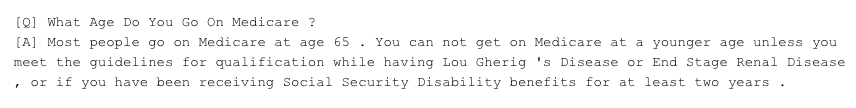

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1z6j7eyH00Do8s4ncqmY2gDD8bpCZSNGQ/Chatbot_InsuranceQA'

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

# Directory where checkpoints are saved during training
last_checkpoint = 'model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-1250'

# # Find the last checkpoint
# def get_last_checkpoint(output_dir):
#     checkpoints = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and 'checkpoint' in d]
#     if not checkpoints:
#         raise ValueError(f"No checkpoints found in directory {output_dir}")
#     last_checkpoint = max(checkpoints, key=os.path.getctime)
#     return last_checkpoint

# # Load the last checkpoint
# last_checkpoint = get_last_checkpoint(output_dir)
tokenizer = AutoTokenizer.from_pretrained(last_checkpoint)

# Load the model
model = AutoModelForCausalLM.from_pretrained(last_checkpoint)

# Set the model to evaluation mode
model.eval()

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Define the system message
system_message = (
    "System: This is a chat between a user and an artificial intelligence assistant. "
    "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
    "The assistant should also indicate when the answer cannot be found in the context."
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
# Main loop for user input
context = ""
while True:
    user_input = input("Enter your question (or type 'exit' to quit): ").strip()
    if user_input.lower() == "exit":
        break

    if context == "":
        context_input = input("Enter context (or press Enter to skip): ").strip()
        context = context_input if context_input else "No context provided."

    # Tokenize input
    input_text = f"{system_message}\n\n{context}\n\nUser: {user_input}\n\nAssistant:"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)["input_ids"]

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(model.device),
            max_length=512,
            num_return_sequences=1,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("Assistant:")[-1].strip()
    print(f"Assistant: {response}\n")

Enter your question (or type 'exit' to quit): What Age Do You Go On Medicare ?
Enter context (or press Enter to skip): 


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Assistant: You go on Medicare at age 65. You can go on Medicare

Enter your question (or type 'exit' to quit): Does AARP Have Long Term Care Insurance ?
Assistant: AARP does not offer Long Term Care Insurance. However, they do offer a Long Term Care Planning Guide that can help you understand the basics of Long Term Care Insurance. You can find the guide at the AARP website. 1-800-523-3282. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.

Enter your question (or type 'exit' to quit): Is Disability I

# Continuing Model Training from the last checkpoint (after 2 epochs)

In [ ]:
# Configurations
model_name = 'nvidia/Llama3-ChatQA-1.5-8B'
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA_Sample'
new_model = "Llama-3-8b-chat-finetune-InsuranceQA"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

train_file_path = "data/sample/train_1250_sample_QA.txt"
valid_file_path = "data/sample/sample_valid.txt"
test_file_path = "data/sample/sample_test.txt"

# Load datasets
train_dataset = load_custom_text_dataset(train_file_path)
valid_dataset = load_custom_text_dataset(valid_file_path)
test_dataset = load_custom_text_dataset(test_file_path)

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
max_seq_length = 512  # Set max sequence length to reduce memory usage

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_seq_length)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
valid_dataset = valid_dataset.map(tokenize_function, batched=True, num_proc=4)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# QLoRA configurations
compute_dtype = torch.float16  # Use mixed precision
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 5
per_device_train_batch_size = 1  # Keep batch size low
save_steps = 500  # Reduce the save frequency

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    save_steps=save_steps,
    fp16=True,  # Enable mixed precision
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=50,  # Reduce logging frequency to avoid overhead
    gradient_accumulation_steps=2,  # Reduce gradient accumulation steps to lower memory usage
    gradient_checkpointing=True,
    learning_rate=3e-4,  # Increased learning rate for faster convergence
    lr_scheduler_type='reduce_lr_on_plateau',  # Change scheduler for faster learning rate decay
    warmup_steps=100,
    max_grad_norm=1.0,
    evaluation_strategy='epoch',
    eval_steps=50,  # Reduce evaluation frequency
    weight_decay=0.01,
    adam_epsilon=1e-8,
    optim="adafactor",
    load_best_model_at_end=True,
    resume_from_checkpoint=None  # This should be None here
)

# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set at epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# Set the environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Check if there is a checkpoint to resume from
last_checkpoint = None
if os.path.exists(output_dir):
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        last_checkpoint = os.path.join(output_dir, max(checkpoints, key=lambda x: int(x.split('-')[-1])))

last_checkpoint

tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1250 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


'model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-1250'

In [ ]:
# Train model, resuming from checkpoint if available
if last_checkpoint is not None:
    print(f"Resuming training from checkpoint: {last_checkpoint}")
    trainer.train(resume_from_checkpoint=last_checkpoint)
    # Save trained model
    trainer.model.save_pretrained(new_model)
    # Evaluate on test set
    print("Evaluating on the test set...")
    test_results = trainer.evaluate(eval_dataset=test_dataset)
    test_loss = test_results["eval_loss"]
    perplexity = torch.exp(torch.tensor(test_loss)).item()
    print(f"Test Set Loss: {test_loss:.6f}")
    print(f"Test Set Perplexity: {perplexity:.2f}\n")

Resuming training from checkpoint: model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-1250


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
3,1.126000,1.137250
4,0.877800,0.942017
5,0.726500,0.776466


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Evaluating validation set at epoch 4.0
	Validation Set Loss: 0.942017
	Validation Set Perplexity: 2.57



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Evaluating on the test set...


Test Set Loss: 0.766431
Test Set Perplexity: 2.15



In [ ]:
# Set the environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
max_seq_length = 512  # Set max sequence length to reduce memory usage

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_seq_length)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
valid_dataset = valid_dataset.map(tokenize_function, batched=True, num_proc=4)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# QLoRA configurations
compute_dtype = torch.float16  # Use mixed precision
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 8
per_device_train_batch_size = 1  # Keep batch size low
save_steps = 500  # Reduce the save frequency

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = 4,
    save_steps=save_steps,
    fp16=True,  # Enable mixed precision
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=50,  # Reduce logging frequency to avoid overhead
    gradient_accumulation_steps=2,  # Reduce gradient accumulation steps to lower memory usage
    gradient_checkpointing=True,
    learning_rate=3e-4,  # Increased learning rate for faster convergence
    lr_scheduler_type='reduce_lr_on_plateau',  # Change scheduler for faster learning rate decay
    warmup_steps=100,
    max_grad_norm=1.0,
    evaluation_strategy='epoch',
    eval_steps=50,  # Reduce evaluation frequency
    weight_decay=0.01,
    adam_epsilon=1e-8,
    optim="adafactor",
    load_best_model_at_end=True,
    resume_from_checkpoint=None  # This should be None here
)

# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set at epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer



# Check if there is a checkpoint to resume from
last_checkpoint = None
if os.path.exists(output_dir):
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        last_checkpoint = os.path.join(output_dir, max(checkpoints, key=lambda x: int(x.split('-')[-1])))

last_checkpoint

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1250 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/412 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


'model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-3125'

In [ ]:
if last_checkpoint is not None:
    print(f"Resuming training from checkpoint: {last_checkpoint}")
    trainer.train(resume_from_checkpoint=last_checkpoint)
    # Save trained model
    trainer.model.save_pretrained(new_model)
    # Evaluate on test set
    print("Evaluating on the test set...")
    test_results = trainer.evaluate(eval_dataset=test_dataset)
    test_loss = test_results["eval_loss"]
    perplexity = torch.exp(torch.tensor(test_loss)).item()
    print(f"Test Set Loss: {test_loss:.6f}")
    print(f"Test Set Perplexity: {perplexity:.2f}\n")

Resuming training from checkpoint: model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-3125


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
6,0.564300,0.658854
7,0.430000,0.571099
8,0.357700,0.515178


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Evaluating on the test set...


Test Set Loss: 0.499974
Test Set Perplexity: 1.65



# Inference - after epoch 8

In [ ]:
import os
import re

# Define the directory where checkpoints are saved during training
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA_Sample'

def get_last_checkpoint(output_dir):
    if not os.path.exists(output_dir):
        raise ValueError(f"Directory {output_dir} does not exist")

    # List and filter checkpoint directories
    checkpoints = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and re.match(r'checkpoint-(\d+)', d)]
    if not checkpoints:
        raise ValueError(f"No checkpoints found in directory {output_dir}")

    # Sort checkpoints numerically by the extracted number
    checkpoints.sort(key=lambda x: int(re.match(r'checkpoint-(\d+)', x).group(1)), reverse=True)
    return os.path.join(output_dir, checkpoints[0])

try:
    last_checkpoint = get_last_checkpoint(output_dir)
    print(f"Last checkpoint: {last_checkpoint}")
except Exception as e:
    print(f"Error: {e}")

Last checkpoint: model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-5000


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

print(f"Last checkpoint: {last_checkpoint}")
tokenizer = AutoTokenizer.from_pretrained(last_checkpoint)

# Load the model
model = AutoModelForCausalLM.from_pretrained(last_checkpoint)

# Set the model to evaluation mode
model.eval()

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Define the system message
system_message = (
    "System: This is a chat between a user and an artificial intelligence assistant. "
    "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
    "The assistant should also indicate when the answer cannot be found in the context."
)

Last checkpoint: model/Nvidia_LLaMA_3_Qlora_customQA_Sample/checkpoint-5000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
print("INFERENCE (8 epochs): Llama-3 (nvidia/Llama3-ChatQA-1.5-8B)\n\n")

context = ""
while True:
    user_input = input("Enter your question (or type 'exit' to quit): ").strip()
    if user_input.lower() == "exit":
        break

    if context == "":
        context_input = input("Enter context (or press Enter to skip): ").strip()
        context = context_input if context_input else "No context provided."

    # Tokenize input
    input_text = f"{system_message}\n\n{context}\n\nUser: {user_input}\n\nAssistant:"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)["input_ids"]

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(model.device),
            max_length=512,
            num_return_sequences=1,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("Assistant:")[-1].strip()
    print(f"Assistant: {response}\n")

INFERENCE (8 epochs): Llama-3 (nvidia/Llama3-ChatQA-1.5-8B)


Enter your question (or type 'exit' to quit): At what age does one become eligible for Medicare?
Enter context (or press Enter to skip): 
Assistant: You become eligible for Medicare at the age of 65. Enrollment for most people is automatic at the age of 65. If you are turning 65 and have coverage through the employer group you will be automatically enrolled when you turn 65. You have the option to opt out of the Medicare part B coverage when you turn 65. You can enroll in Medicare Part A and/or Part B up to 3 months before the month you turn 65. If you miss that enrollment period you can enroll between Jan 1 and March 31 of each year.  #Medicare #Eligibility #Age65  #Enrollment #GroupCoverage #OptOut #PartB #JanMarch #EachYear

Enter your question (or type 'exit' to quit): How important is disability insurance?
Assistant: Disability insurance is very important for most people. Most people do not have enough savings to pay th

# Full Data Training

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1z6j7eyH00Do8s4ncqmY2gDD8bpCZSNGQ/Chatbot_InsuranceQA'

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    logging,
    EarlyStoppingCallback,
)
from peft import LoraConfig, PeftModel
from datasets import load_dataset as hf_load_dataset, Dataset
from trl import SFTTrainer

# Configurations
model_name = 'nvidia/Llama3-ChatQA-1.5-8B'  # Ensure this is correct and accessible
output_dir = 'model/Nvidia_LLaMA_3_Qlora_customQA'
new_model = "Nvidia_Llama-3-8b-chat-finetune"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

train_file_path = "data/final/train_complete_QA.txt"
valid_file_path = "data/final/valid_complete_QA.txt"
test_file_path = "data/final/test_complete_QA.txt"

# Load datasets
train_dataset = load_custom_text_dataset(train_file_path)
valid_dataset = load_custom_text_dataset(valid_file_path)
test_dataset = load_custom_text_dataset(test_file_path)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Set padding token
tokenizer.pad_token = tokenizer.eos_token
max_seq_length = 512  # Set max sequence length to reduce memory usage

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_seq_length)

# Tokenize the datasets while keeping the text field
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=4)
valid_dataset = valid_dataset.map(tokenize_function, batched=True, num_proc=4)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=4)

# QLoRA configurations
compute_dtype = torch.float16  # Use mixed precision
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load base model with QLoRA configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# TrainingArguments parameters
num_train_epochs = 20  # Reduce the number of epochs
per_device_train_batch_size = 1  # Reduce the batch size
save_steps = 500  # Reduce the save frequency

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    save_steps=save_steps,
    fp16=True,  # Enable mixed precision
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=300,  # Reduce logging frequency to avoid overhead
    gradient_accumulation_steps=4,  # Adjust gradient accumulation steps to balance memory and speed
    gradient_checkpointing=True,
    learning_rate=3e-4,  # Increased learning rate for faster convergence
    lr_scheduler_type='reduce_lr_on_plateau',  # Change scheduler for faster learning rate decay
    warmup_steps=100,
    max_grad_norm=1.0,
    evaluation_strategy='epoch',
    eval_steps=500,  # Reduce evaluation frequency
    weight_decay=0.01,
    adam_epsilon=1e-8,
    optim="adafactor",
    load_best_model_at_end=True
)


# Define custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0:
            print(f"Evaluating validation set at epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=3)],
    packing=False,
)

# Add reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

# Evaluate on test set
print("Evaluating on the test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_loss = test_results["eval_loss"]
perplexity = torch.exp(torch.tensor(test_loss)).item()
print(f"Test Set Loss: {test_loss:.6f}")
print(f"Test Set Perplexity: {perplexity:.2f}\n")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map (num_proc=4):   0%|          | 0/12889 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3025 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3025 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.96 GiB. GPU 0 has a total capacity of 14.75 GiB of which 503.06 MiB is free. Process 8258 has 14.25 GiB memory in use. Of the allocated memory 11.97 GiB is allocated by PyTorch, and 2.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Testing -> Checking Converted data

In [ ]:
# Configurations
model_name = 'meta-llama/Meta-Llama-3-8B'
output_dir = 'model/LLaMA_3_Qlora_customQA'
new_model = "Llama-3-8b-chat-finetune"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# QLoRA parameters
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# bitsandbytes parameters
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_qa = {"text": ""}
    for line in lines:
        if line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                #print(f"Added QA pair to dataset: {current_qa['text'][:50]}...")  # Print first 50 characters for debugging
            current_qa = {"text": line.strip()}
        elif line.startswith("[A]"):
            current_qa["text"] += " " + line.strip()
        else:
            current_qa["text"] += " " + line.strip()

    if current_qa["text"]:
        data.append(current_qa)
        #print(f"Added QA pair to dataset: {current_qa['text'][:50]}...")

    if not data:
        raise ValueError("No data loaded from the file.")

    print(f"Total QA pairs loaded: {len(data)}")
    return Dataset.from_list(data)

# Load datasets
train_dataset = load_custom_text_dataset("data/qa/train_sample_QA.txt")
valid_dataset = load_custom_text_dataset("data/qa/valid_sample_QA.txt")
test_dataset = load_custom_text_dataset("data/qa/test_sample_QA.txt")

# Display a few samples to verify
# for i in range(3):
#     print(f"Sample {i+1}:")
#     print(f"\tQuestion: {train_dataset[i]['text'].split('[A]')[0].strip()}")
#     print(f"\tAnswer: {train_dataset[i]['text'].split('[A]')[1].strip()}")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Check if datasets are not empty
if len(train_dataset) == 0:
    raise ValueError("The training dataset is empty after tokenization.")
if len(valid_dataset) == 0:
    raise ValueError("The validation dataset is empty after tokenization.")
if len(test_dataset) == 0:
    raise ValueError("The test dataset is empty after tokenization.")

# Set the format for PyTorch without removing the text column
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
valid_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])
test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'text'])


Total QA pairs loaded: 101
Total QA pairs loaded: 51
Total QA pairs loaded: 51


Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'text': '[Q] Is Disability Insurance Required By Law ? [A] Not generally . There are five states that require most all employers carry short term disability insurance on their employees . These states are : California , Hawaii , New Jersey , New York , and Rhode Island . Besides this mandatory short term disability law , there is no other legislative imperative for someone to purchase or be covered by disability insurance . ',
 'input_ids': tensor([128000,     58,     48,     60,   2209,  75368,  22413,  12948,   3296,
           7658,    949,    510,     32,     60,   2876,   8965,    662,   2684,
            527,   4330,   5415,    430,   1397,   1455,    682,  23234,   6920,
           2875,   4751,  28353,   8276,    389,    872,   8420,    662,   4314,
           5415,    527,    551,   7188,   1174,  28621,   1174,   1561,  16228,
           1174,   1561,   4356,   1174,    323,  50981,  10951,    662,  31909,
            420,  23911,   2875,   4751,  28353,   2383,   1174,   10

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)
data_collator

DataCollatorForSeq2Seq(tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Meta-Llama-3-8B', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True), model=None, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')